In [1]:
#this method works on time space --> needs an original wf which is not the reconstructed one. What you can do: 1) single wf and single fft 2) taking avg of CORRELATED wfs 
# not ideal for the avg of uncorrelated wfs (avg(fft) != fft(avg)) as you have seen comparing A VS B

In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import fft
from scipy import stats
from scipy.signal import get_window
import glob
import time

def filtering_func(freqs, all_magnitudes, all_phases, f1, f2): #passing 2D complex numbers as fft
    avg_fft = np.mean(np.abs(all_magnitudes), axis = 0) 
    n = np.max(avg_fft)
    
    noise_fft = all_magnitudes.copy()
    
    #average the rows
    abs_fft = np.mean(np.abs(all_magnitudes), axis = 0)
    phases = np.mean(all_phases, axis = 0)
    valid_indices = np.where((freqs >= f1) & (freqs <= f2) | (freqs >= -f2) & (freqs <= -f1))[0]

    fft_in_range = abs_fft[valid_indices]
    print(f'fft_in_range: {fft_in_range/n} ')

    peak = np.max(fft_in_range)

    local_peak_indices = np.where(abs_fft[valid_indices] == peak)[0]
    general_peak_indices = valid_indices[local_peak_indices]
    print(f"general_peak_indices: {general_peak_indices}")
    print(f"abs_fft[general_peak_indices]/n: {abs_fft[general_peak_indices]/n}")

    peak_f = freqs[general_peak_indices]
    print(f"peak_f: {peak_f}")

    peak_phase = phases[general_peak_indices]
    print(f"peak_phase: {peak_phase}")

    print(f'sum: {np.sum(np.isin(freqs, peak_f))}')
    mask = np.ones(noise_fft.shape, dtype=bool)
    mask[:, general_peak_indices] = False
    noise_fft[mask] = complex(0, 0)
    return noise_fft, peak_f, peak_phase

In [3]:
hour = '15.42'
day = '08082024'

In [4]:
file_pattern = f"../../Waveforms/{day}/{day}_{hour}/{day}_{hour}_wf.csv/{day}_{hour}_wf_*.csv"
file_list = glob.glob(file_pattern)

amplitudes_list = []

if not file_list:
    print("No files found for the given pattern.")
else:
    for i, file in enumerate(file_list):
        df = pd.read_csv(file)
        if i == 0:
            print(df.iloc[:, 0])
            print(df.iloc[:, 1])
            times = pd.to_numeric(df.iloc[1:, 0], errors = 'coerce').values
        amplitudes = pd.to_numeric(df.iloc[1:, 1], errors='coerce').values
        amplitudes_list.append(amplitudes)
        
all_amplitudes = np.stack(amplitudes_list, axis = 0)

0               (us)
1         0.00000000
2         0.00080000
3         0.00160000
4         0.00240000
            ...     
62500    49.99920067
62501    50.00000067
62502    50.00080067
62503    50.00160067
62504    50.00240067
Name: Time, Length: 62505, dtype: object
0               (mV)
1        -1.96850400
2        -1.57480300
3        -1.18110200
4        -0.78740150
            ...     
62500     0.00000000
62501     0.39370070
62502    -0.39370070
62503    -1.18110200
62504    -1.18110200
Name: Channel D, Length: 62505, dtype: object


In [5]:
N = len(times)
print(f"len(times): {N}")
print(f"{times}")

len(times): 62504
[0.00000000e+00 8.00000000e-04 1.60000000e-03 ... 5.00008007e+01
 5.00016007e+01 5.00024007e+01]


In [6]:
all_magnitudes = fft.fft(all_amplitudes, axis = 1)
all_phases = np.angle(all_magnitudes)

In [7]:
avg_wf = np.mean(all_amplitudes, axis = 0)

## FFT

In [8]:
span = times[-1]
print(f"span: {span}") 
f_s = len(times) / span
print(f"f_s = {f_s}")
freqs = fft.fftfreq(len(times), 1/f_s) #window lenght, sample spacing
print(f"last freq: {freqs[-1]}") ##this should be the half of f_s.
print(f"len(freqs): {len(freqs)}")
print(freqs)

span: 50.00240067
f_s = 1250.0199822905822
last freq: -0.019999039778103515
len(freqs): 62504
[ 0.          0.01999904  0.03999808 ... -0.05999712 -0.03999808
 -0.01999904]


In [9]:
avg_fft = fft.fft(avg_wf) 
n = np.max(avg_fft)

c:\Users\giuly\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\giuly\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


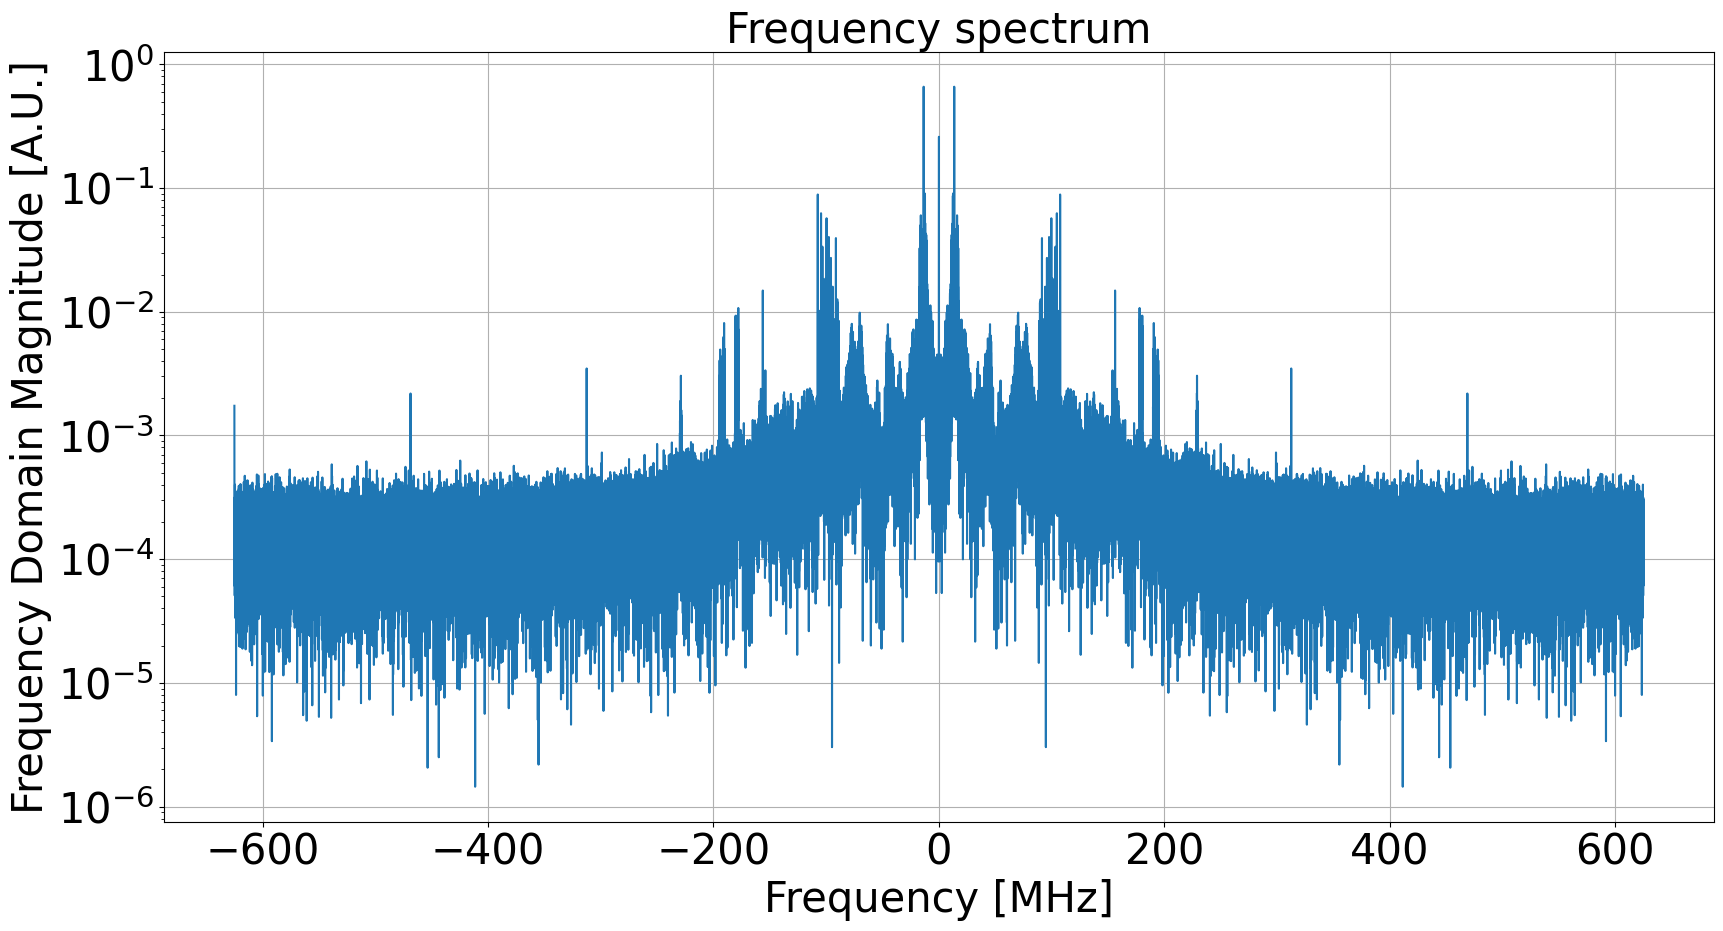

In [10]:
freqs_shifted = fft.fftshift(freqs)
avg_fft_shifted = fft.fftshift(avg_fft)

plt.figure(figsize=(20, 10))
plt.plot(freqs_shifted, np.abs(avg_fft_shifted)/n)

plt.title('Frequency spectrum', fontsize = 30)
plt.xlabel('Frequency [MHz]', fontsize = 30)
plt.xticks(fontsize = 30)
plt.ylabel('Frequency Domain Magnitude [A.U.]', fontsize = 30)
plt.yticks(fontsize = 30)
plt.semilogy()
plt.grid(True)
#plt.semilogx()

#plt.savefig("250724_17.23/fft.pdf", format = "pdf", bbox_inches="tight")
plt.show()

In [11]:
if (N%2 == 0):
    pos_freqs = freqs[:round((N/2))]
    pos_avg_fft = avg_fft[:round((N/2))]
else:
    pos_freqs = freqs[:round((N-1)/2 + 1)]
    pos_avg_fft = avg_fft[:round((N-1)/2 + 1)]

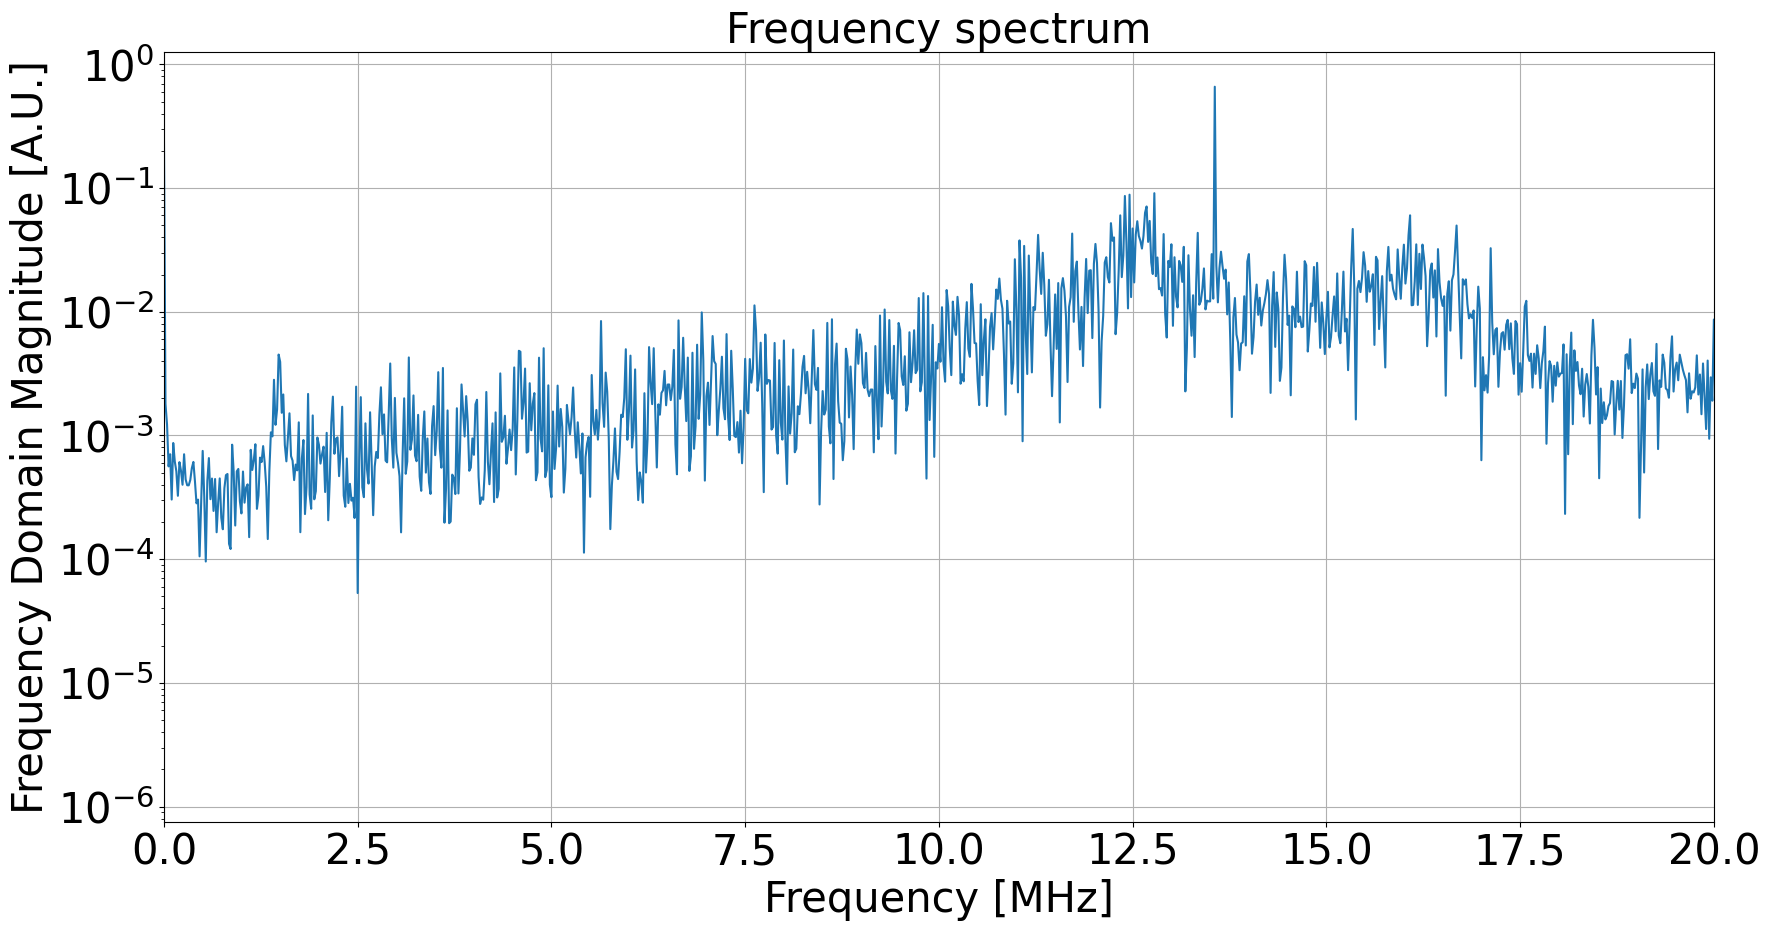

In [12]:
plt.figure(figsize=(20, 10))
plt.plot(pos_freqs, np.abs(pos_avg_fft)/n)

plt.title('Frequency spectrum', fontsize = 30)
plt.xlabel('Frequency [MHz]', fontsize = 30)
plt.xticks(fontsize = 30)
plt.ylabel('Frequency Domain Magnitude [A.U.]', fontsize = 30)
plt.yticks(fontsize = 30)
plt.semilogy()
plt.xlim(0, 20)
plt.grid(True)
#plt.semilogx()

#plt.savefig("250724_17.23/fft.pdf", format = "pdf", bbox_inches="tight")
plt.show()

In [13]:
f1 = 13
f2 = 14

## Filtering

In [14]:
noise_fft, peak_f, peak_phases = filtering_func(freqs, all_magnitudes, all_phases, f1, f2)
avg_noise_wfs = fft.ifft(noise_fft, axis = 1)

fft_in_range: [0.06283239 0.03836001 0.03408982 0.05894811 0.0573373  0.05700084
 0.06036589 0.04658497 0.03064742 0.04018227 0.04000562 0.02854666
 0.03123717 0.03880201 0.02754103 0.02897443 0.04401564 0.04050957
 0.03473978 0.03830908 0.02583741 0.02622025 0.04378405 0.02395749
 0.02985617 0.04429852 0.05011606 1.         0.05478877 0.03267317
 0.03099009 0.03202164 0.06089555 0.07325747 0.03913789 0.02814406
 0.02508365 0.02611231 0.02871157 0.02163785 0.02546372 0.0283484
 0.02039627 0.02136207 0.02659739 0.02020158 0.02367976 0.02724602
 0.02937242 0.04111193 0.04111193 0.02937242 0.02724602 0.02367976
 0.02020158 0.02659739 0.02136207 0.02039627 0.0283484  0.02546372
 0.02163785 0.02871157 0.02611231 0.02508365 0.02814406 0.03913789
 0.07325747 0.06089555 0.03202164 0.03099009 0.03267317 0.05478877
 1.         0.05011606 0.04429852 0.02985617 0.02395749 0.04378405
 0.02622025 0.02583741 0.03830908 0.03473978 0.04050957 0.04401564
 0.02897443 0.02754103 0.03880201 0.03123717 0.02

In [15]:
# times_new_2 = np.arange(N) / f_s_new

#noise_wf = np.cos(peak_f[0]* 2*np.pi * times + peak_phases[0])

avg_noise_wf = np.mean(avg_noise_wfs.real, axis = 0)


# plt.figure(figsize=(20, 10))
# plt.plot(times, avg_noise_wfs.real[0], color = 'blue', label = 'noise - cosine waveform')
# plt.plot(times, avg_noise_wfs.real[1], color = 'blue', label = 'noise - cosine waveform')
# plt.plot(times, avg_noise_wfs.real[2], color = 'blue', label = 'noise - cosine waveform')
# plt.plot(times, avg_noise_wfs.real[3], color = 'blue', label = 'noise - cosine waveform')
# plt.plot(times, avg_noise_wfs.real[4], color = 'blue', label = 'noise - cosine waveform')

# plt.title(' ', fontsize = 50)
# plt.xlabel(r'Times [$\mu$s]', fontsize = 50)
# plt.xticks(fontsize = 40)
# plt.ylabel('Amplitudes [A.U.]', fontsize = 50)
# plt.yticks(fontsize = 40)
# plt.grid(True)
# plt.xlim(0, 0.1)
# plt.legend(loc = 'best', fontsize = 40)

# #plt.savefig("../Results/080824_15.42/method2_noise_wf_test2.pdf", format = "pdf", bbox_inches="tight")
# plt.show()


#avg_noise_wf -= np.mean(avg_noise_wf)

In [16]:
avg_filtered_wf = avg_wf - avg_noise_wf

In [17]:
A = max(avg_noise_wf.real)
f = peak_f[0]
phi = peak_phases[0]
coswave = A*np.cos(f*np.pi*2*times + phi)

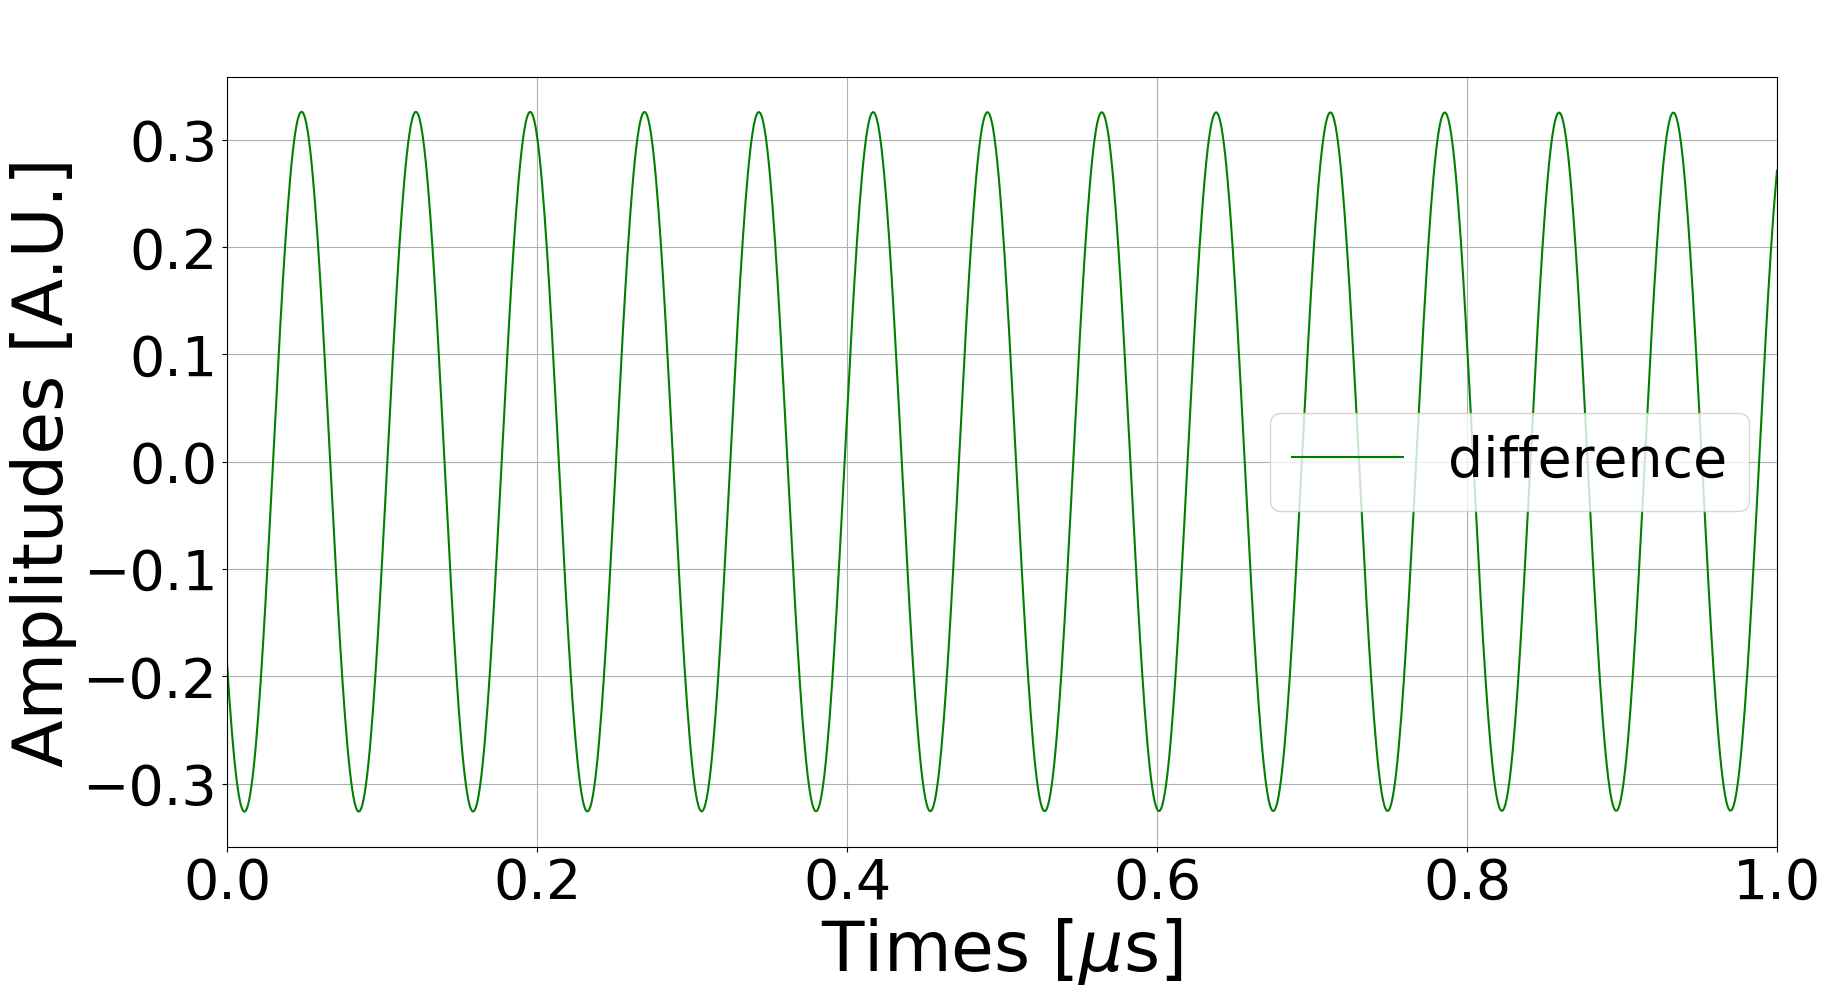

In [31]:
plt.figure(figsize=(20, 10))
#plt.errorbar(freqs, avg_fft_au, yerr = stds_fft, fmt='o', markersize = 2, ecolor='red', capsize = 3, capthick=1, elinewidth=1)
plt.plot(times, avg_noise_wf - coswave, color = 'green', label = 'difference')
#plt.plot(times, coswave, linestyle = '--', color = 'orange', label = 'cosine wave')

plt.title(' ', fontsize = 50)
plt.xlabel(r'Times [$\mu$s]', fontsize = 50)
plt.xticks(fontsize = 40)
plt.ylabel('Amplitudes [A.U.]', fontsize = 50)
plt.yticks(fontsize = 40)
plt.grid(True)
plt.xlim(0, 1)
plt.legend(loc = 'best', fontsize = 40)

#plt.savefig("../Results/080824_15.42/method2_noise_wf_test2.pdf", format = "pdf", bbox_inches="tight")
plt.show()


In [19]:
declareted_phase = peak_phases[0]
print(f"declareted phase: {declareted_phase*180/np.pi}")
real_phase = np.arcsin(avg_noise_wf.real[0]/A)
print(f"real phase: {real_phase*180/np.pi}")
print(f"difference: {(real_phase - declareted_phase)*180/np.pi}")

declareted phase: 21.62065859970982
real phase: 41.256981178186905
difference: 19.636322578477078


## Compare to original waveform

In [20]:
#original_wf = fft.irfft(avg_fft_au) working in time domain, the original wf should not be the reconstructed one. But also, is the avg wf a good 'original wf'?
#original_wf = np.mean(all_amplitudes, axis=0)

avg_reconstructed_wf = fft.ifft(avg_fft)

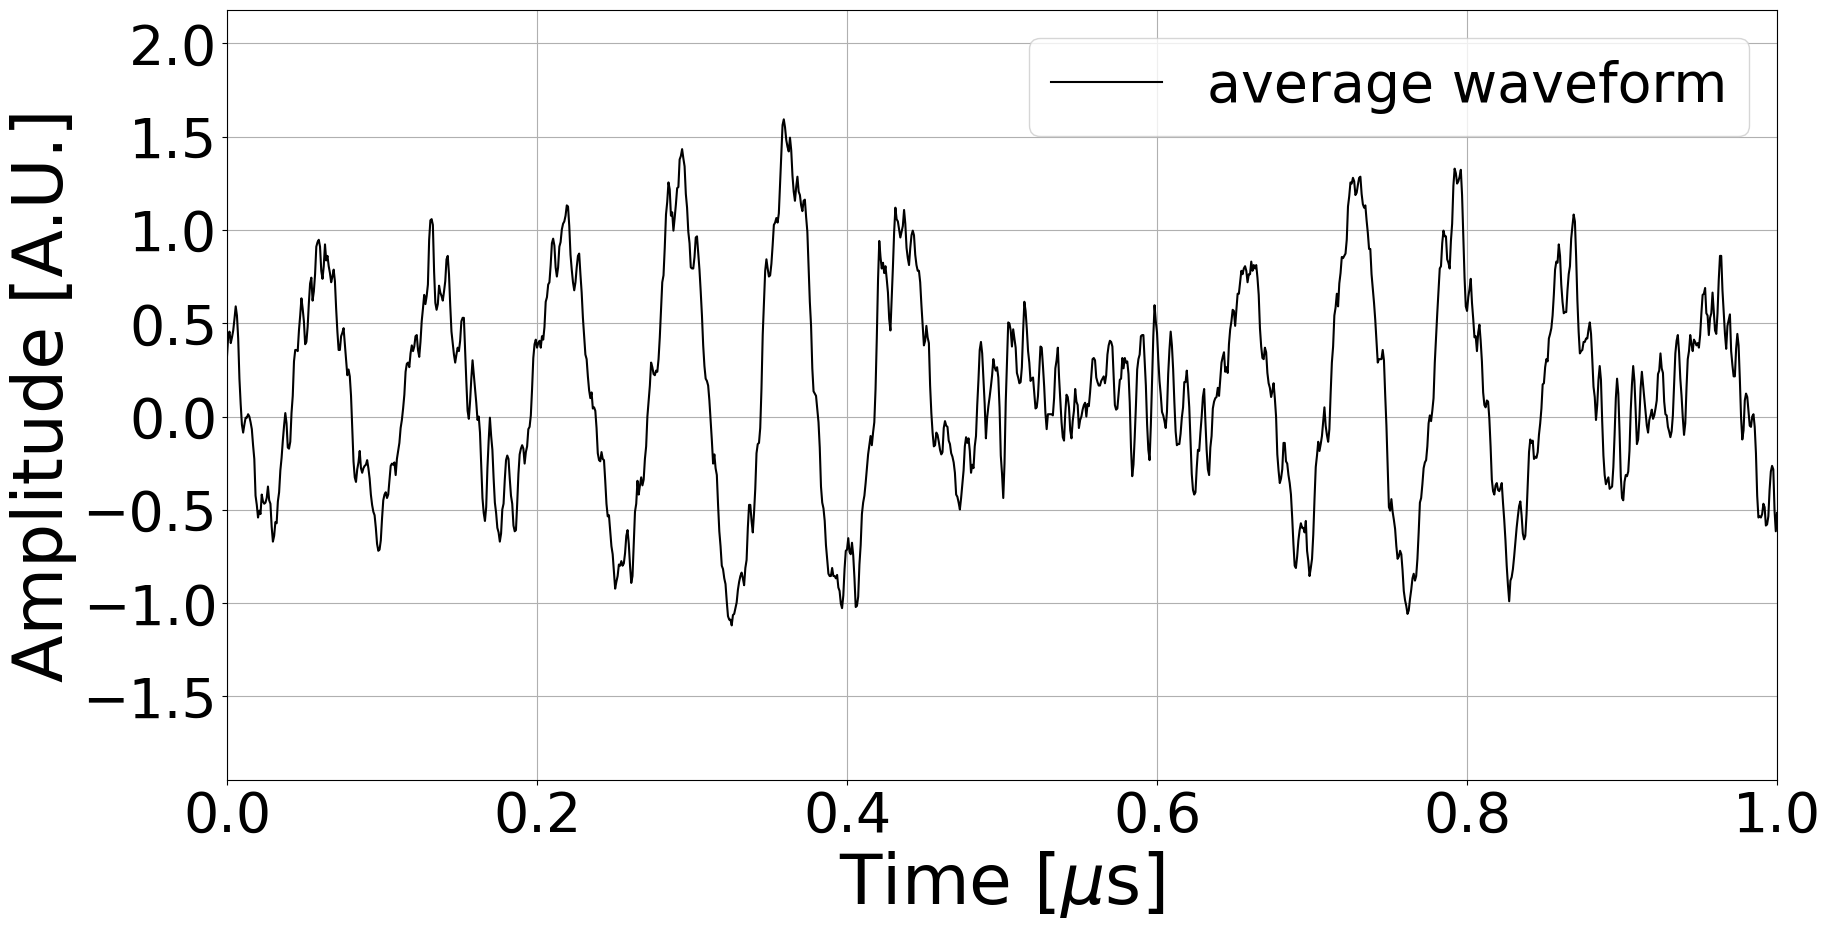

In [21]:
plt.figure(figsize = (20, 10))
plt.plot(times, avg_wf, label = 'average waveform', color = 'black')

plt.title('', fontsize = 50)
plt.xlabel(r'Time [$\mu$s]', fontsize = 50)
plt.xticks(fontsize = 40)
plt.ylabel('Amplitude [A.U.]', fontsize = 50)
plt.yticks(fontsize = 40)
plt.grid(True)
plt.xlim(0, 1)
plt.legend(loc = 'best', fontsize = 40)

#plt.savefig("Results/simple_ifft.png", format = "png", bbox_inches="tight")
#plt.savefig("../Results/080824_15.42/method2_original_wf_test2.pdf", format = "pdf", bbox_inches="tight")
plt.show()

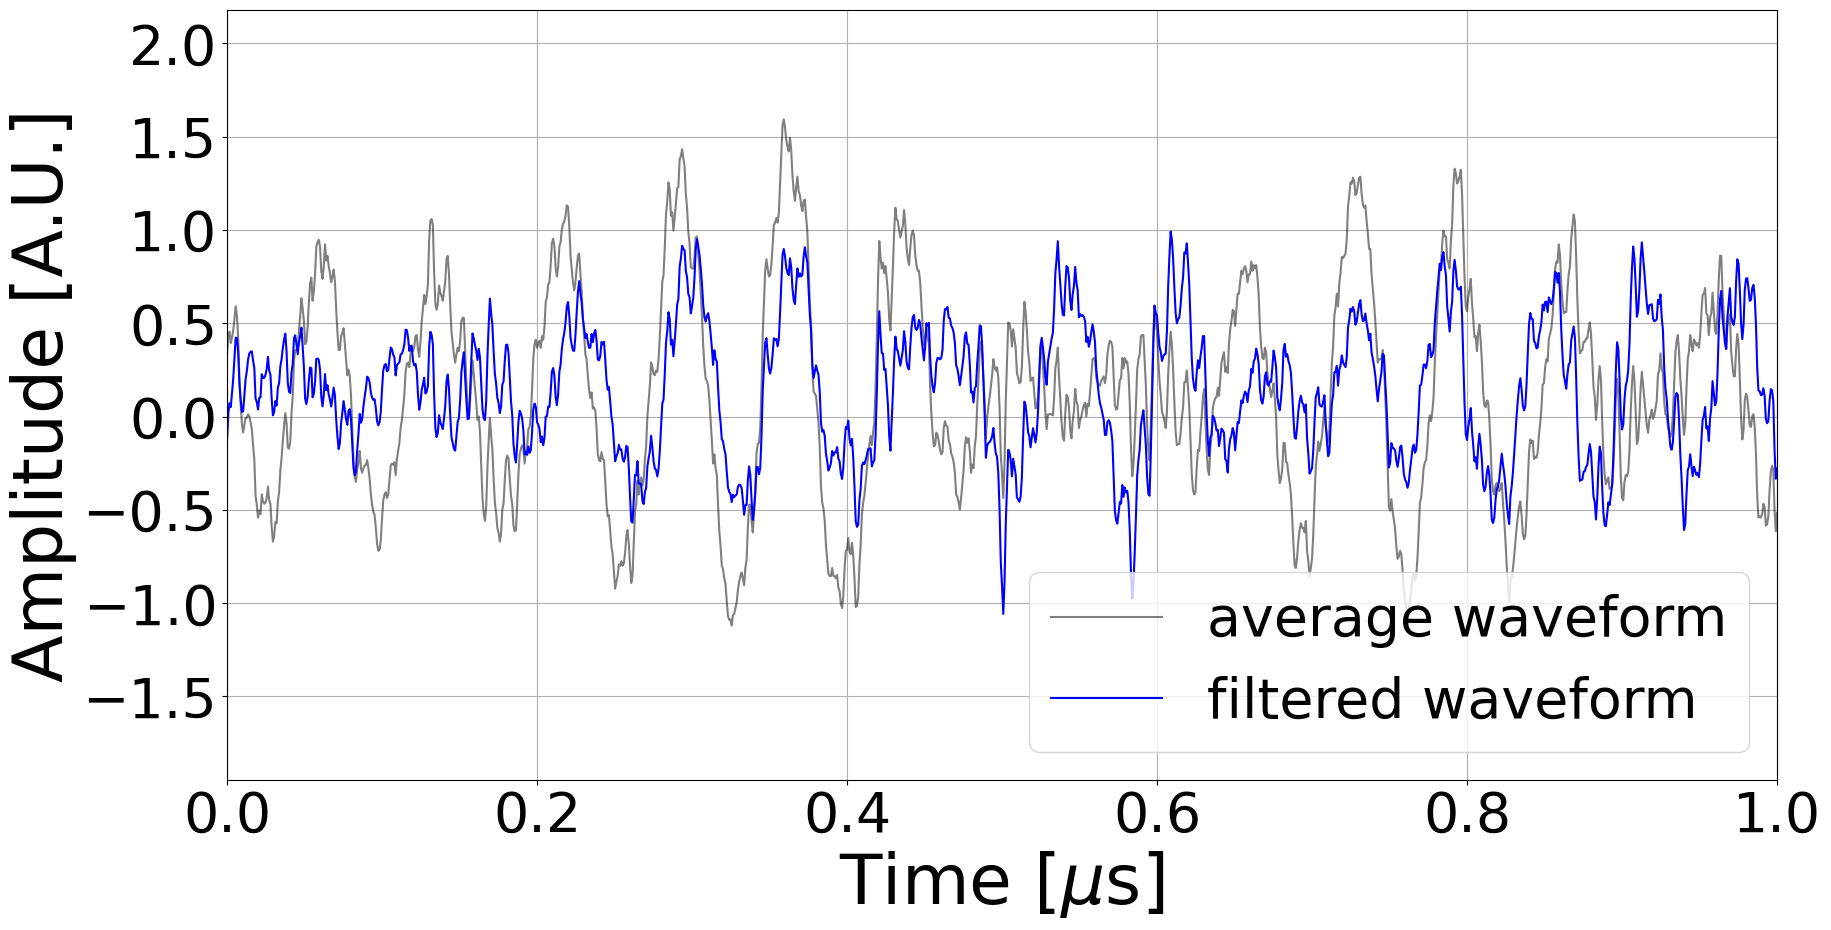

In [22]:
plt.figure(figsize = (20, 10))
plt.plot(times, avg_wf, label = 'average waveform', color = 'black', alpha = 0.5)
plt.plot(times, avg_wf - avg_noise_wf, label = 'filtered waveform', color = 'blue')

plt.title('', fontsize = 50)
plt.xlabel(r'Time [$\mu$s]', fontsize = 50)
plt.xticks(fontsize = 40)
plt.ylabel('Amplitude [A.U.]', fontsize = 50)
plt.yticks(fontsize = 40)
plt.grid(True)
plt.xlim(0, 1)
plt.legend(loc = 'best', fontsize = 40)

#plt.savefig("Results/simple_ifft.png", format = "png", bbox_inches="tight")
#plt.savefig("../Results/080824_15.42/method2_filtered_wf_test2.pdf", format = "pdf", bbox_inches="tight")
plt.show()

# Make sure reconstructed waveform is the same as original waveform

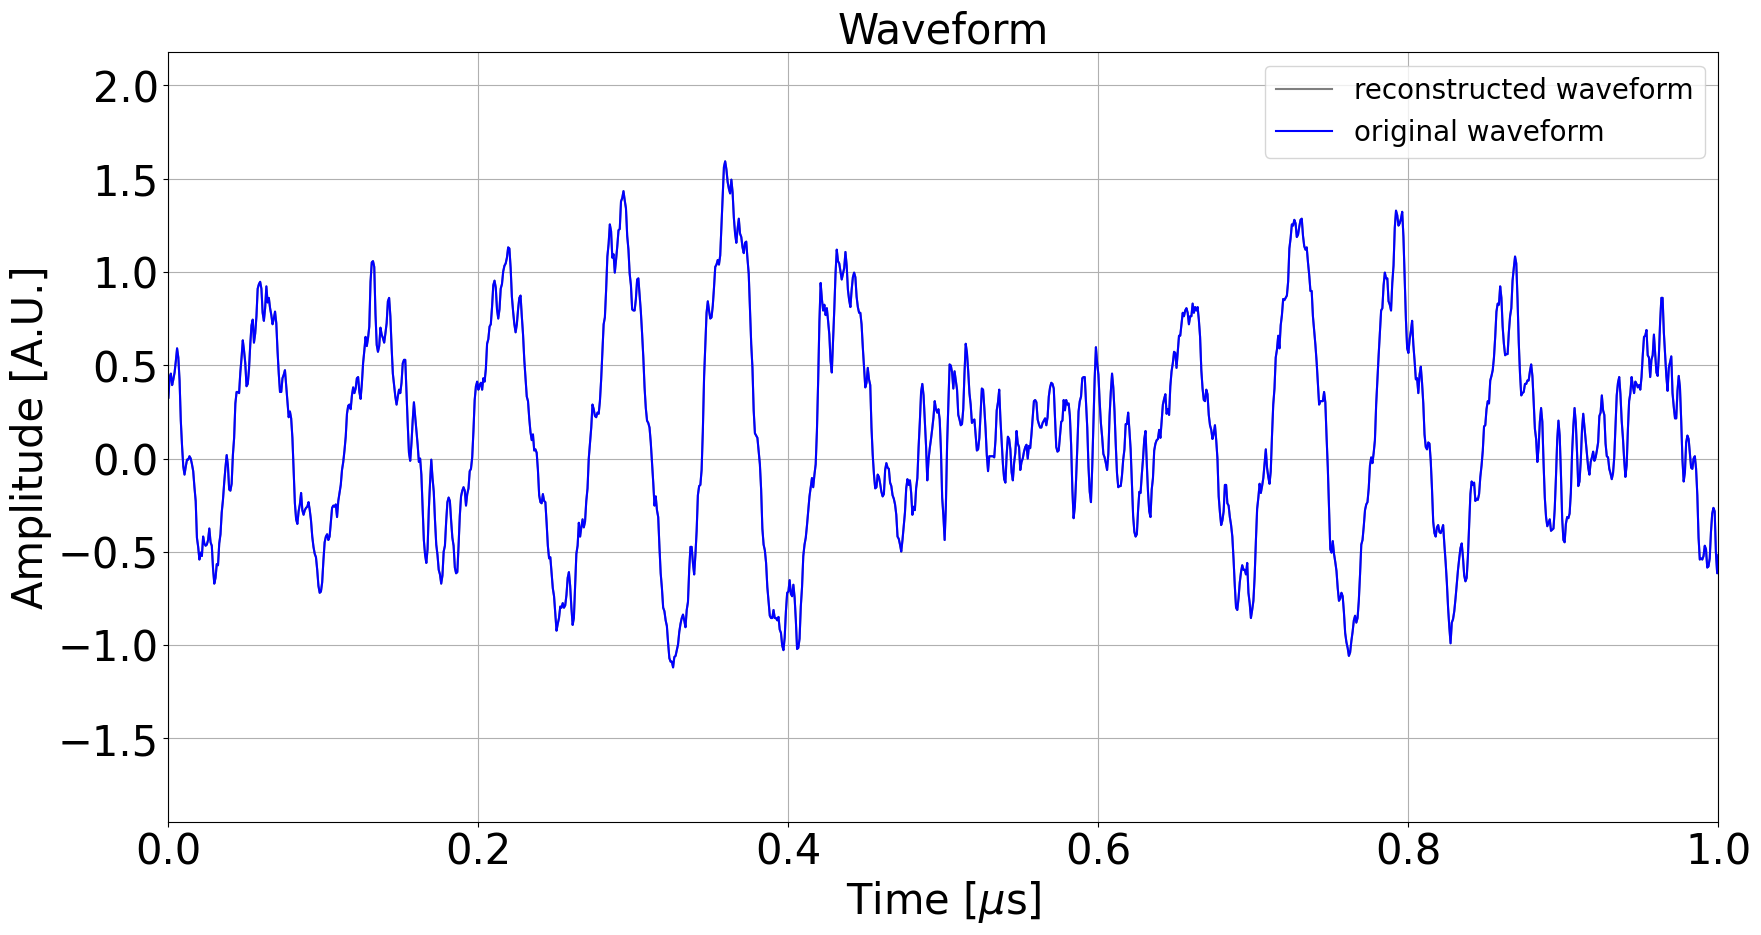

In [23]:
plt.figure(figsize = (20, 10))
plt.plot(times, avg_reconstructed_wf.real, label = 'reconstructed waveform', color = 'black', alpha = 0.5)
plt.plot(times, avg_wf, label = 'original waveform', color = 'blue')

plt.title('Waveform', fontsize = 30)
plt.xlabel(r'Time [$\mu$s]', fontsize = 30)
plt.xticks(fontsize = 30)
plt.ylabel('Amplitude [A.U.]', fontsize = 30)
plt.yticks(fontsize = 30)
plt.grid(True)
plt.xlim(0, 1)
plt.legend(loc = 'best', fontsize = 20)

#plt.savefig("Results/simple_ifft.png", format = "png", bbox_inches="tight")
#plt.savefig("Results/simple_ifft.pdf", format = "pdf", bbox_inches="tight")
plt.show()

In [24]:
avg_filtered_fft = fft.fft(avg_filtered_wf)

c:\Users\giuly\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\transforms.py:992: ComplexWarning: Casting complex values to real discards the imaginary part
  self._points[:, 1] = interval


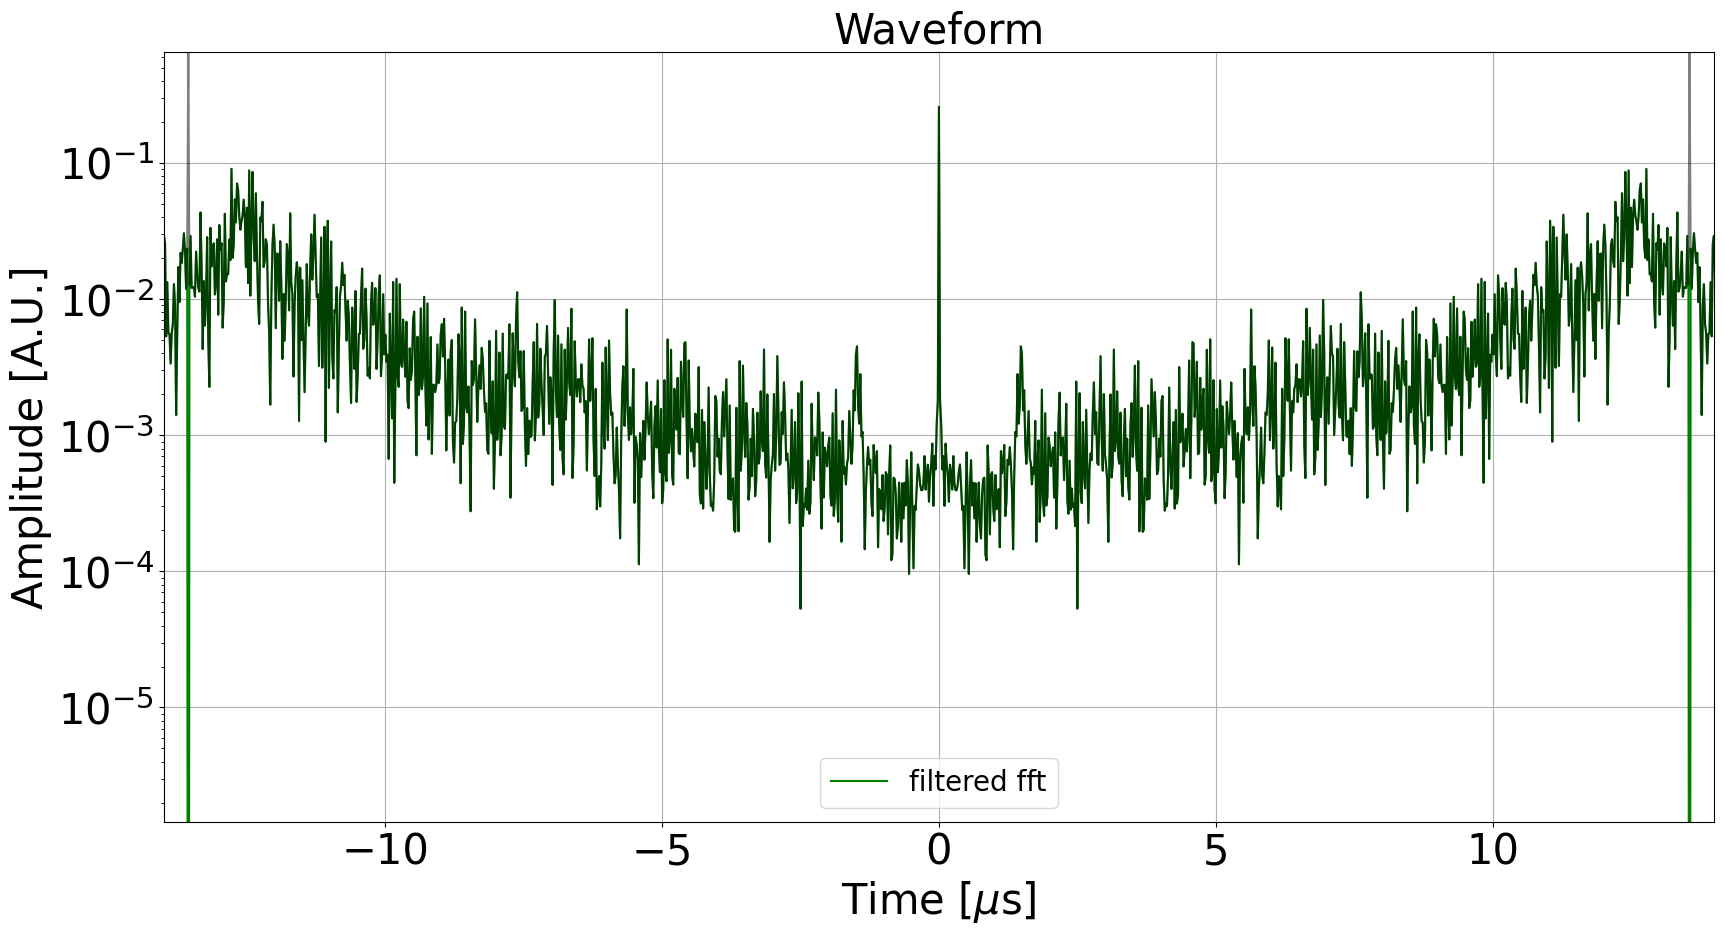

In [25]:
avg_filtered_fft_shifted = fft.fftshift(avg_filtered_fft)

plt.figure(figsize = (20, 10))
plt.plot(freqs_shifted, np.abs(avg_filtered_fft_shifted)/n, label = 'filtered fft', color = 'green')
plt.plot(freqs_shifted, np.abs(avg_fft_shifted)/n, color = 'k', alpha = 0.5)

plt.title('Waveform', fontsize = 30)
plt.xlabel(r'Time [$\mu$s]', fontsize = 30)
plt.xticks(fontsize = 30)
plt.ylabel('Amplitude [A.U.]', fontsize = 30)
plt.yticks(fontsize = 30)
plt.grid(True)
plt.semilogy()
plt.ylim([min(np.abs(avg_fft_shifted)/n), max(np.abs(avg_fft_shifted)/n)])  # Adjust the y-axis range
plt.xlim(-f2, f2)
plt.legend(loc = 'best', fontsize = 20)

#plt.savefig("Results/simple_ifft.png", format = "png", bbox_inches="tight")
#plt.savefig("Results/simple_ifft.pdf", format = "pdf", bbox_inches="tight")
plt.show()

In [26]:
# avg_filtered_phases = fft.fftshift(avg_filtered_phases)
# plt.figure(figsize = (20, 10))
# plt.scatter(freqs, avg_filtered_phases, label = 'filtered phases', color = 'green')
# plt.axvline(13.55934897, color = 'red', alpha = 0.2)

# plt.title('Waveform', fontsize = 30)
# plt.xlabel(r'Time [$\mu$s]', fontsize = 30)
# plt.xticks(fontsize = 30)
# plt.ylabel('Amplitude [A.U.]', fontsize = 30)
# plt.yticks(fontsize = 30)
# plt.grid(True)
# plt.xlim(13, 14)
# plt.ylim(-0.5, 0.5)
# plt.legend(loc = 'best', fontsize = 20)

# #plt.savefig("Results/simple_ifft.png", format = "png", bbox_inches="tight")
# #plt.savefig("Results/simple_ifft.pdf", format = "pdf", bbox_inches="tight")
# plt.show()

In [27]:
# index = np.where(np.isclose(freqs, 13.55934897))[0]
# phase_value = avg_filtered_phases[index]
# print(phase_value)

In [28]:
#Inconsistent Phase Across Frequency Components: When you zero out parts of the FFT, you are altering the phase of the remaining components. If you don’t handle this correctly, it can lead to sudden phase shifts when transforming back to the time domain.
#fix the phase info thing